# Simulation

In [1]:
# %load ./../../../games/connect-four/connect-four.py
import numpy as np

class ConnectFourSimulator:
	"""Creates a connect-4 board and simulates it, returning states and rewards for any taken action.

	The creates board is a 6 x 7 (rows x cols) array. Empty fields are denoted by 0.
	Tokens placed by player one are denoted by '1' and player two uses '-1'.
	Every field is part of the state and has it's own index, simply counting from 0 to 41 along the rows
	like so [
		[0, 1, 2, 3, 4, 5, 6],
		[7, 8, 9, 10, 11, 12, 13],
		...
		[35, 36, 37, 38, 39, 40, 41]
	]
	"""
	def __init__(self):
		self.width = 7
		self.height = 6
		self.board = np.zeros(shape=(self.height, self.width))
		self.PLAYER1 = 1
		self.PLAYER2 = -1
		self.DRAW = 0
		self.current_player = self.PLAYER1
		self.valid_actions = list(range(self.width))
		self.__game_over = False

	def take_action(self, action):
		"""Executes the action and returns the next state and the received reward."""
		active_player = self.current_player
		inactive_player = self.__negated_player(active_player)
		if not self.__action_is_valid(action):
			return self.__game_over, self.board, active_player, -2, inactive_player, 0

		self.__play_move(action)

		self.__game_over = self.__game_is_over(action)
		if self.__game_over:
			winner = self.__winner(action)
			if winner == self.DRAW:
				return self.__game_over, self.board, active_player, 0, inactive_player, 0
			elif winner == self.PLAYER1:
				return self.__game_over, self.board, active_player, 1, inactive_player, -1
			else:
				return self.__game_over, self.board, active_player, -1, inactive_player, 1

		return self.__game_over, self.board, active_player, 0, inactive_player, 0

	def print_board(self):
		board = self.board
		board = np.where(board == 1, "X", board)
		board = np.where(board == "-1.0", "O", board)
		print(np.where(board == "0.0", "-", board))

	def __play_move(self, action):
		"""Takes an action and executes it."""
		x, y = self.__coordinates_from_action(action)
		self.board[y][x] = self.current_player
		self.current_player = self.__negated_player(self.current_player)

	def __action_is_valid(self, action):
		"""Checks if the intended action is a valid one or if it breaks the rules of the game."""
		# if 41 > action < 0:
		# 	return False
		# x, y = self.__coordinates_from_action(action)
		# if x >= self.width or y >= self.height:
		# 	return False
		#
		# height_x = self.__column_height(x)
		#
		# if y != height_x:
		# 	return False
		# return True
		is_valid = action in self.valid_actions

		if is_valid:
			next_valid_action = action + self.width
			if next_valid_action < self.width * self.height:
				self.valid_actions.append(next_valid_action)
			self.valid_actions.remove(action)
		return is_valid

	def __column_height(self, x):
		"""Returns the height of a column which is equal to the amount of tokens placed."""
		column = self.board[:, x]
		return np.count_nonzero(column)

	def __game_is_over(self, last_action):
		"""Returns True if the game is over and False otherwise."""
		if np.count_nonzero(self.board) >= 42:
			return True

		lines = self.__extract_lines(last_action)

		for line in lines:
			if self.__winner_in_line(line) != 0:
				return True

		return False

	def __extract_lines(self, last_action):
		"""Extracts the horizontal, vertical and the diagonal lines going through the last action"""
		x, y = self.__coordinates_from_action(last_action)

		row = self.board[y]
		column = self.board[:, x]
		top_down_diagonal = self.board.diagonal(x - y)

		mirrored_x = self.width - 1 - x
		bot_up_diagonal = np.fliplr(self.board).diagonal(mirrored_x - y)

		return row, column, top_down_diagonal, bot_up_diagonal

	def __winner(self, last_action):
		"""Returns the winner's number or 0 if the game resulted in a draw (Requires the game to have ended)."""
		lines = self.__extract_lines(last_action)

		for line in lines:
			winner = self.__winner_in_line(line)
			if winner != 0:
				return winner

		return 0

	def __winner_in_line(self, line):
		"""Checks if a line contains a winner and returns his number if yes and 0 otherwise."""
		token_sum = 0
		for token in line:
			token_sum += token
			if token_sum == 4 * self.PLAYER1:
				return self.PLAYER1
			if token_sum == 4 * self.PLAYER2:
				return self.PLAYER2
			if token_sum < 0 < token or token_sum > 0 > token:
				token_sum = 0
		return 0

	def __coordinates_from_action(self, action):
		"""Translates an action into (x, y) / (column, row) coordinates."""
		x = action % self.width
		y = action // self.width
		return x, y

	def __negated_player(self, player):
		"""Returns the player not passed to the function (Player1 if Player2 is passed and the other way around)."""
		return self.PLAYER2 if self.current_player == self.PLAYER1 else self.PLAYER1


In [2]:
game = ConnectFourSimulator()

val = input()
while val != "q":
    game_over, board, _, _, _, _ = game.take_action(int(val))
    print(game_over)
    print(board)
    print("------------------------------------")
    val = input()

print(game.take_action(3))
print(game.take_action(4))
print(game.take_action(10))
print(game.take_action(5))
print(game.take_action(17))
print(game.take_action(6))
print(game.take_action(24))

# Agent

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(42, 64)
        #self.fc1.weight.data.fill_(0.0)
        #self.fc1.bias.data.fill_(0.0)
        self.fc2 = nn.Linear(64, 64)
        #self.fc2.weight.data.fill_(0.0)
        #self.fc2.bias.data.fill_(0.0)
        self.fc3 = nn.Linear(64, 42)
        #self.fc3.weight.data.fill_(0.0)
        #self.fc3.bias.data.fill_(0.0)
        
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
import random

import torch
import torch.optim as optim

class DeepQPytorchAgent:
    def __init__(self, learning_rate=0.0001, discount=0.95, exploration_rate=1.0, iterations=10_000, trained_model=None):
        self.q_table = np.zeros(shape=(42, 42))
        self.learning_rate = learning_rate
        self.discount = discount
        self.exploration_rate = exploration_rate
        self.exploration_delta = exploration_rate / iterations
        
        self.input_count = 42
        self.output_count = 42
        
        self.define_model(trained_model)
    
    def define_model(self, trained_model):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        if trained_model:
            self.model = trained_model.to(self.device)
        else:
            self.model = Model().to(self.device)
        
        #self.optimizer = optim.SGD(self.model.parameters(), lr=self.learning_rate)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
    
    def get_Q(self, state_batch):
        return self.model(state_batch)
        
    def next_action(self, state, valid_actions):
        if random.random() < self.exploration_rate:
            return self.random_action(valid_actions)
        else:
            return self.greedy_action(state, valid_actions)
        
    def random_action(self, valid_actions):
        action = random.randrange(0, 42)
        while not action in valid_actions:
            action = random.randrange(0, 42)
        return action
    
    def greedy_action(self, state_batch, valid_actions):
        #print("States before:", state_batch)
        #print("Greedy:", torch.max(self.get_Q(state_batch), 1)[1])
        Q_values = self.get_Q(state_batch)[0]
        Q_values = self.normalized_Q(Q_values, valid_actions)
        action = torch.max(Q_values, 0)[1]
        assert action in valid_actions, "Only valid actions may be selected"
        return action
        #return torch.max(self.get_Q(state_batch), 1)[1]
    
    def normalized_Q(self, Q_values, valid_actions):
        '''Takes a single Q value array and sets invalid actions to -1.'''
        for x in range(0, 41):
            if not x in valid_actions:
                Q_values[x] = -1.0
        return Q_values
        
    def update(self, old_states, new_states, actions, rewards, valid_actions_batch):
        self.train(old_states, new_states, actions, rewards, valid_actions_batch)
        # TODO: Maybe change algorithm?
        if self.exploration_rate > 0:
            self.exploration_rate = max(0.2, self.exploration_rate - self.exploration_delta)
        
    def train(self, old_states, next_states, actions, rewards, valid_actions_batch):
        old_state_values = self.get_Q(old_states)
        next_state_values = self.get_Q(next_states).detach()
        
        #print("Max:", torch.max(next_state_values, dim=1)[0])
        for x in range(len(next_state_values)):
            valid_actions = valid_actions_batch[x]
            next_state_values[x] = self.normalized_Q(next_state_values[x], valid_actions)
            
        new_rewards = rewards + self.discount * torch.max(next_state_values, dim=1)[0]
        updated_state_values = old_state_values.clone().detach() # Check if detach could cause problems
        for index, (reward, action) in enumerate(zip(new_rewards, actions)):
            updated_state_values[index][action] = reward
        
        #print("Old state values:", old_state_values)
        #print("New reward:", new_rewards)
        #print("Updated:", updated_state_values)
        #print("Actions:", actions)
        #print("SelectedByActions:", updated_state_values[actions])
        #updated_state_values[actions] = new_rewards
        
        # in your training loop:
        self.optimizer.zero_grad()   # zero the gradient buffers
        loss = F.smooth_l1_loss(old_state_values, updated_state_values)
        loss.backward()
        self.optimizer.step()    # Does the update

# Orchestration

In [5]:
from collections import namedtuple

Transition = namedtuple('Transition',
                        ('old_state', 'next_state', 'action', 'reward', 'valid_actions'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [6]:
def transition(game, active, passive):
    old_state = np.copy(game.board)
    old_state = torch.tensor(old_state.flatten(), device=active.device).float()
    valid_actions = torch.tensor(game.valid_actions).clone().long()
    
    action = active.next_action(torch.unsqueeze(old_state, dim=0), valid_actions)
    #action = torch.tensor(action, device=active.device).long()
    
    game_over, next_state, _, reward, _, _ = game.take_action(action)
    next_state = torch.tensor(next_state.flatten(), device=active.device).float()
    reward = torch.tensor(reward, device=active.device).float()
        
    if game_over:
        return True, old_state, next_state, action, reward, valid_actions
            
    # if the move was invalid, add data and repeat
    if reward < 0:
        return False, old_state, next_state, action, reward, valid_actions
        
    # Play another move until the move is a right one and add the data to the memory
    passive_reward = -1
    counting_stars = 0
    while passive_reward < 0:
        passive_action = passive.next_action(torch.unsqueeze(next_state, dim=0), game.valid_actions)
        game_over, _, _, passive_reward, _, cur_reward = game.take_action(passive_action)
        
        counting_stars += 1
        if counting_stars % 1000 == 0:
                print("Counting:", counting_stars)
        
    cur_reward = torch.tensor(cur_reward, device=active.device).float()
    if game_over:
        return True, old_state, next_state, action, cur_reward, valid_actions
    return False, old_state, next_state, action, reward, valid_actions

In [7]:
def optimize_model(active, passive, memory, batch_size=128):
    if len(memory) < batch_size:
        return

    batch = memory.sample(batch_size)
    batch = Transition(*zip(*batch))
    #print("States before:\n", batch.old_state)
    #print("Next states before:\n", batch.next_state)
    #print("Actions before:\n", batch.action)
    #print("Rewards before:\n", batch.reward)
    old_state_batch = torch.stack(batch.old_state, dim=0)
    next_state_batch = torch.stack(batch.next_state, dim=0)
    action_batch = torch.tensor(batch.action, device=active.device)
    reward_batch = torch.tensor(batch.reward, device=active.device)
    #valid_actions_batch = torch.stack(batch.valid_actions, dim=0)
    valid_actions_batch = batch.valid_actions
    #action_batch = torch.stack(batch.action, dim=0)
    #reward_batch = torch.stack(batch.reward, dim=0)
    
    return active.update(old_state_batch, next_state_batch, action_batch, reward_batch, valid_actions_batch)

In [8]:
game = ConnectFourSimulator()

In [9]:
#%matplotlib notebook
import matplotlib.pyplot as plt

In [10]:
epochs = 100 # Number of games to play
batch_size = 128
memory = ReplayMemory(10000)
active = DeepQPytorchAgent(iterations=epochs*batch_size*20)
passive = DeepQPytorchAgent(iterations=epochs*batch_size*20)

In [11]:
example_board = np.array([
    [0,0,0,1,-1,0,0],
    [0,0,0,1,-1,0,0],
    [0,0,0,1,-1,0,0],
    [0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0]
])
example_board = torch.tensor(example_board.flatten()).to(active.device).float()

In [12]:
y_batch = torch.unsqueeze(example_board, dim=0)
print(y_batch)
print(active.next_action(y_batch, [0, 1, 2, 3, 4, 5, 6]))
print(active.get_Q(y_batch))
print(torch.max(active.normalized_Q(active.get_Q(y_batch)[0], list(range(7))), 0)[1])

tensor([[ 0.,  0.,  0.,  1., -1.,  0.,  0.,  0.,  0.,  0.,  1., -1.,  0.,  0.,
          0.,  0.,  0.,  1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],
       device='cuda:0')
0
tensor([[-0.1222,  0.3007, -0.1598,  0.3016, -0.3448,  0.3003,  0.3311,  0.2142,
         -0.2104, -0.5564,  0.0696, -0.1571, -0.2803, -0.3656, -0.2932,  0.2341,
          0.1172,  0.1617, -0.0783, -0.0634, -0.3856,  0.1783, -0.2165,  0.4328,
          0.1907, -0.3452, -0.3517, -0.3849, -0.0471,  0.4139, -0.2694,  0.2710,
         -0.2912,  0.1197, -0.0630, -0.2242, -0.1111, -0.0730, -0.0519,  0.1220,
         -0.2119, -0.7330]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor(6, device='cuda:0')


In [13]:
import time

# Using memory replay
total_rewards = [ [torch.tensor(0)] for epoch in range(epochs) ]
total = [torch.tensor(0)]
print(total_rewards)
start = int(round(time.time() * 1000))
for epoch in range(epochs):
    #invalids = []
    #invalid = 0
    #for iteration in range(1, iterations + 1):
    print("Epoch:", epoch)
    game_over = False
    game = ConnectFourSimulator()
    while not game_over:
        optimize_model(active, passive, memory, batch_size)
        passive.model.load_state_dict(active.model.state_dict())
                      
        game_over, old_state, next_state, action, reward, valid_actions = transition(game, active, passive)

        memory.push(old_state, next_state, action, reward, valid_actions)
        total_rewards[epoch].append(total_rewards[epoch][-1] + reward)
        total.append(total[-1] + reward)
end = int(round(time.time() * 1000))
print("Time taken:", (end - start))
print("Time taken in sec:", (end - start) / 1000)
# Time without batching: 657sec (10), 95 (5), 399 (5)
# Time with batching: 12 (5)

[[tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)], [tensor(0)]

RuntimeError: Expected object of backend CUDA but got backend CPU for argument #2 'other'

In [14]:
total_rewards = [ [ val.tolist() for val in rewards ] for rewards in total_rewards ]
total = [ val.tolist() for val in total ]

In [15]:
print("Average moves to finish:", len(total) / epochs)

Average moves to finish: 7.71


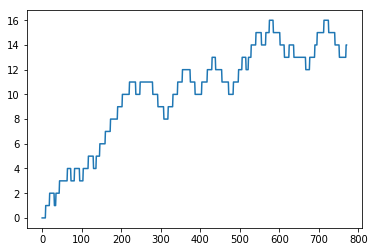

In [16]:
plt.figure()
#plt.plot(total_rewards[0])
plt.plot(total)

print(invalids)

In [17]:
# Error in the end comes from the network predicting a result, which is wrong and since exploration is way down it almost
# always predicts the same action which is always wrong. Should somehow learn though (maybe replay necessary?)

# Notes
- Use memory replay --> DONE
- Maybe higher rewards needed for backpropagation of Q values?
- View reward function by playing vs the network
- View network output for certain states
<br>
<br>
- Do I even backpropagate the reward to other states than the winning one in any way?
- Maybe the problem are few games (not enough possibilities learned) -> More iterations like 10_000 games instead of iterations
- Learning rate?
<br>
<br>
- Rework memory replay batch size and epochs analog to pytorch tutorial
- Plot metrics (e.g. total reward every iteration)
- Rework code --> Readability and reusability
- Maybe rework greedy policy
- Test the pytorch agent on the dungeon example --> DONE: Works
- Try increasing the performance (For running in the cloud) -> Use timer
- Maybe no punishment for invalid moves?
- Pass possible moves to network?
- Only give out copies of the state... --> FIXED (This literally ruined every single state in the memory...)
- Copy pytorch tensors via .copy().detach() (maybe more effectively possible as well?)
<br>
<br>
- How to choose rewards and how does the agent learn the rules (punishment for invalid moves?)
- How much training is needed for a game?
- Evaluation tactics: Total reward
- Model too big?
- Don't copy model to update agent? --> Constantly creating optimizer and agent again and again
- Only learning negative values atm --> Why?
- Ignore invalid moves
- Limit reward to between -1 and 1
<br>
<br>
Takeaways:
- Batching is so much quicker, it is absurd

In [18]:
empty_board = np.zeros(shape=(6, 7))
empty_board = torch.tensor(empty_board.flatten(), device=active.device).float()
empty_board = torch.unsqueeze(empty_board, dim=0)

In [19]:
example_board = np.array([
    [0,0,0,1,-1,0,0],
    [0,0,0,1,-1,0,0],
    [0,0,0,1,-1,0,0],
    [0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0]
])
example_board2 = np.array([
    [0,0,1,1,-1,0,0],
    [0,0,0,1,-1,0,0],
    [0,0,0,1,-1,0,0],
    [0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0]
])

example_board = torch.tensor(example_board.flatten(), device=active.device).float()
example_board = torch.unsqueeze(example_board, dim=0)
example_board2 = torch.tensor(example_board2.flatten(), device=active.device).float()
example_board2 = torch.unsqueeze(example_board2, dim=0)

In [20]:
print(active.next_action(example_board, [0, 1, 2, 24, 25, 5, 6]))
print(active.get_Q(example_board))
print(torch.max(active.normalized_Q(active.get_Q(example_board)[0], [0, 1, 2, 24, 25, 5, 6]), 0)[1])

0
tensor([[1.7817, 1.8056, 1.8363, 1.7683, 1.7023, 1.8090, 1.7902, 1.8220, 1.7254,
         1.7433, 1.7455, 1.7800, 1.7517, 1.7895, 1.8076, 2.0135, 1.8600, 1.7538,
         1.8729, 1.7863, 1.7216, 1.9410, 2.0671, 1.8555, 2.1595, 1.7571, 1.7574,
         1.9285, 1.8858, 1.8301, 1.6871, 1.8170, 1.7476, 1.6158, 1.2748, 1.8565,
         1.4448, 1.8000, 1.6915, 1.8570, 1.8705, 1.6324]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor(24, device='cuda:0')


In [21]:
print(active.next_action(example_board2, [0, 1, 9, 24, 25, 5, 6]))
print(active.get_Q(example_board2))
print(torch.max(active.normalized_Q(active.get_Q(example_board2)[0], [0, 1, 9, 24, 25, 5, 6]), 0)[1])

6
tensor([[1.7856, 1.8101, 1.8420, 1.7721, 1.7085, 1.8110, 1.7933, 1.8234, 1.7277,
         1.7493, 1.7491, 1.7816, 1.7536, 1.7946, 1.8118, 2.0174, 1.8639, 1.7581,
         1.8766, 1.7885, 1.7248, 1.9450, 2.0731, 1.8571, 2.1622, 1.7607, 1.7629,
         1.9325, 1.8875, 1.8329, 1.6906, 1.8204, 1.7509, 1.6185, 1.2788, 1.8607,
         1.4470, 1.8047, 1.6966, 1.8581, 1.8747, 1.6361]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor(24, device='cuda:0')


In [22]:
print(active.next_action(empty_board, range(7)))
print(active.get_Q(empty_board))
print(torch.max(active.normalized_Q(active.get_Q(empty_board)[0], range(7)), 0)[1])

4
tensor([[1.7646, 1.7940, 1.8222, 1.7538, 1.6875, 1.7944, 1.7801, 1.8068, 1.7053,
         1.7278, 1.7306, 1.7674, 1.7367, 1.7726, 1.7930, 2.0023, 1.8519, 1.7400,
         1.8610, 1.7653, 1.7089, 1.9322, 2.0486, 1.8473, 2.1413, 1.7470, 1.7519,
         1.9142, 1.8769, 1.8160, 1.6806, 1.8016, 1.7325, 1.6030, 1.2626, 1.8393,
         1.4361, 1.7867, 1.6698, 1.8479, 1.8589, 1.6233]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor(2, device='cuda:0')


game = ConnectFourSimulator()
val = input()
while val != "q":
    game_over, board, _, _, _, _ = game.take_action(int(val))
    print(game_over)
    print(board)
    print("------------------------------------")
    if not game_over:
        confirmation = "r"
        while confirmation == "r":
            pc_action = active.next_action(board)
            print(pc_action)
            confirmation = input()
            if confirmation == "c":
                game_over, board, _, _, _, _ = game.take_action(pc_action)
                print(game_over)
                print(board)
    val = input()

In [ ]:
games = memory.sample(len(memory))

In [ ]:
terminal_states = [ game for game in games if game[3] == 100 or game[3] == -100 ]

In [ ]:
for state in terminal_states:
    print("Before:\n", state[0])
    print("After:\n", state[1])
    print("With action:", state[2])
    print("---------------------------------------")

In [ ]:
for state in memory.memory[:42]:
    print("Before:\n", state[0])
    print("After:\n", state[1])
    print("With action:", state[2])
    print("Reward:", state[3])
    print("---------------------------------------")